# Evaluating Different Embedding Methods


As AI is becoming more prevalent in today's society, it is important to recognize the best way to use AI tools to best answer questions. One question is the classification task for drugs. For example, does a certain drug have the capability of penetrating the blood-brain barrier? It is important to determine the best method for the most accurate results so that AI can be used as a reputable tool for verifying chemical research in real world applications.

In this experiment, both embedding models (LLaMA, and text-embedding-ada-002) are compared against each other. Both models are tasked to classify different chemical properties from the BBBP, HIV, BACE, and Clintox datasets. Four different classifier is used to calculate f1 scores and the mean and standard deviation for these f1 scores. It is hypothesized that the OpenAI model, text-embedding-ada-002, would outperform LLaMA; however, this experiment aims to find a conclusion.





# Load Datasets

Datasets are loaded from the [deepChem](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#moleculenet-cheatsheet) package. Everything is saved to [Google Drive](https://drive.google.com/drive/folders/10rbqUFkNkvD4DnZaAAepHZ86LqInsU0X?usp=sharing)

* Blood-Brain Barrier Penetration designed for the modeling and prediction of barrier permeability

* Experimentally measured abilities to inhibit HIV replication.

* Provides bindings results for a set of inhibitors of human beta-secretase (BACE-1)

* Drugs that were FDA approved but failed clinical trials

# References

* [A merged molecular representation learning for molecular properties prediction with a web-based service
](https://www.nature.com/articles/s41598-021-90259-7)   Chem-bert [source code](https://github.com/HyunSeobKim/CHEM-BERT)

* MolRoPE-BERT: An enhanced molecular representation with Rotary Position Embedding for molecular property prediction
Author links open overlay panel [MolRoPE-BERT](https://www.sciencedirect.com/science/article/pii/S1093326322002236)

* [SMILES-BERT](https://dl.acm.org/doi/abs/10.1145/3307339.3342186) pre-train on ZINC data

* Basic Molecular Representation for Machine Learning
From SMILES to Word Embedding and Graph Embedding [code tutorial](https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76)

In [24]:
#Installing Dependecies

!pip install openai
!pip install rdkit
!pip install tiktoken
!pip install transformers
#!pip install deepchem

#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#import deepchem as dc
import numpy as np
import openai
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics._plot.precision_recall_curve import average_precision_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from google.colab import drive
from sklearn.decomposition import PCA
import torch
import transformers as t
import os
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('seaborn-v0_8-whitegrid')
os.environ['OPENAI_API_KEY'] = Your Key
drive.mount('/content/drive')
openai.api_key  = (Your Key)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# download the embeddings from the link in our github and save them in your desired path and call that path for reading
PATH = "/content/drive/MyDrive/Shaghayegh Sadeghi/Drug embedding/Moleculenet/Evaluating_Embeddings2/"

In [29]:
DATASETS = ['bbbp', 'bace_classification', 'hiv','clintox','DDI_SMILES','DDI_Desc']

MODELS = ['GPT','llama-7B','llama2-7B']

CLASSIFIERS = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'GradientBoostingClassifier']

In [64]:
#Retrieving SMILES and labels
data = {}
DATASETS = ['bbbp', 'bace_classification', 'hiv','clintox']
for dataset in DATASETS:
  data[dataset] = pd.read_csv(PATH+dataset+'.csv',sep=',',index_col=[0])

In [65]:
model_name_mapping = {'GPT':'GPT','llama-7B':'LLaMA','llama2-7B':'LLaMA2'}
dataset_name_mapping = {'bbbp':'BBBP', 'bace_classification':'BACE C', 'hiv': 'HIV','clintox':'ClinTox'}

# Renaming the keys in the data dictionary
data = {dataset_name_mapping[key]: value for key, value in data.items() if key in dataset_name_mapping}


## Load Embeddings

In [32]:
DATASETS = ['bbbp', 'bace_classification', 'hiv','clintox','DDI_SMILES','DDI_Desc']

embeddings = {}
for model in MODELS:
    embeddings[model] = {}

    for name in DATASETS:
        df = pd.read_csv(PATH + name + '_' + model + '.csv', sep='\t' if name in ['DDI_SMILES', 'DDI_Desc'] else ',', index_col=0)

        if name in ['DDI_SMILES', 'DDI_Desc']:
            col_index = df.columns.get_loc('0')
            df = df.iloc[:, col_index:]

        embeddings[model][name] = df



In [33]:
model_name_mapping = {'GPT':'GPT','llama-7B':'LLaMA','llama2-7B':'LLaMA2'}
dataset_name_mapping = {'bbbp':'BBBP', 'bace_classification':'BACE C', 'hiv': 'HIV','clintox':'ClinTox','DDI_SMILES':'DDI_SMILES','DDI_Desc':'DDI_Desc'}

new_embeddings = {}
for old_model_name, datasets in embeddings.items():
    new_model_name = model_name_mapping.get(old_model_name, old_model_name)
    new_embeddings[new_model_name] = {}

    for old_dataset_name, data in datasets.items():
        new_dataset_name = dataset_name_mapping.get(old_dataset_name, old_dataset_name)
        new_embeddings[new_model_name][new_dataset_name] = data



# Cosine Similarity between the embeddings of each smiles in each model

In [34]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def average_cosine_similarity(df: pd.DataFrame) -> float:

    cosine_sim_matrix = cosine_similarity(df)

    upper_triangular_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
    upper_triangular_values = cosine_sim_matrix[upper_triangular_indices]

    average_similarity = np.mean(upper_triangular_values)

    return average_similarity



In [35]:
MODELS = ['GPT','LLaMA','LLaMA2']
DATASETS = ['BBBP', 'BACE C', 'HIV','ClinTox','DDI_SMILES','DDI_Desc']


In [36]:
print('Embedding')
SimCos=pd.DataFrame(columns=['Model','DataSet','Avarage Cosine Similarity'])
for model in MODELS:
  for d in DATASETS:
    print('avarage cosine sim:',model, d,':', average_cosine_similarity(new_embeddings[model][d]))
    SimCos=SimCos.append({'Model': model, 'DataSet': d, 'Avarage Cosine Similarity':average_cosine_similarity(new_embeddings[model][d])}, ignore_index=True)



Embedding
avarage cosine sim: GPT BBBP : 0.9168205426534617
avarage cosine sim: GPT BACE C : 0.9352081821733401
avarage cosine sim: GPT HIV : 0.9185490780167868
avarage cosine sim: GPT ClinTox : 0.9116050770068851
avarage cosine sim: GPT DDI_SMILES : 0.9093948980516193
avarage cosine sim: GPT DDI_Desc : 0.7580715185579344
avarage cosine sim: LLaMA BBBP : 0.8750863386047567
avarage cosine sim: LLaMA BACE C : 0.9581716874094923
avarage cosine sim: LLaMA HIV : 0.9068243714187145
avarage cosine sim: LLaMA ClinTox : 0.8923596214879493
avarage cosine sim: LLaMA DDI_SMILES : 0.7886165898758791
avarage cosine sim: LLaMA DDI_Desc : 0.46223766592299215
avarage cosine sim: LLaMA2 BBBP : 0.8402049079963013
avarage cosine sim: LLaMA2 BACE C : 0.9490944796160632
avarage cosine sim: LLaMA2 HIV : 0.869167158102639
avarage cosine sim: LLaMA2 ClinTox : 0.8512059150088725
avarage cosine sim: LLaMA2 DDI_SMILES : 0.7891900917885354
avarage cosine sim: LLaMA2 DDI_Desc : 0.554184866568345


In [39]:
SimCos.to_csv('Result_simcos_GvL.csv')
SimCos.rename(columns={'Model': 'Embedding'}, inplace=True)
SimCos

,Embedding,DataSet,Avarage Cosine Similarity
0,GPT,BBBP,0.916821
1,GPT,BACE C,0.935208
2,GPT,HIV,0.918549
3,GPT,ClinTox,0.911605
4,GPT,DDI_SMILES,0.909395
5,GPT,DDI_Desc,0.758072
6,LLaMA,BBBP,0.875086
7,LLaMA,BACE C,0.958172
8,LLaMA,HIV,0.906824
9,LLaMA,ClinTox,0.892360


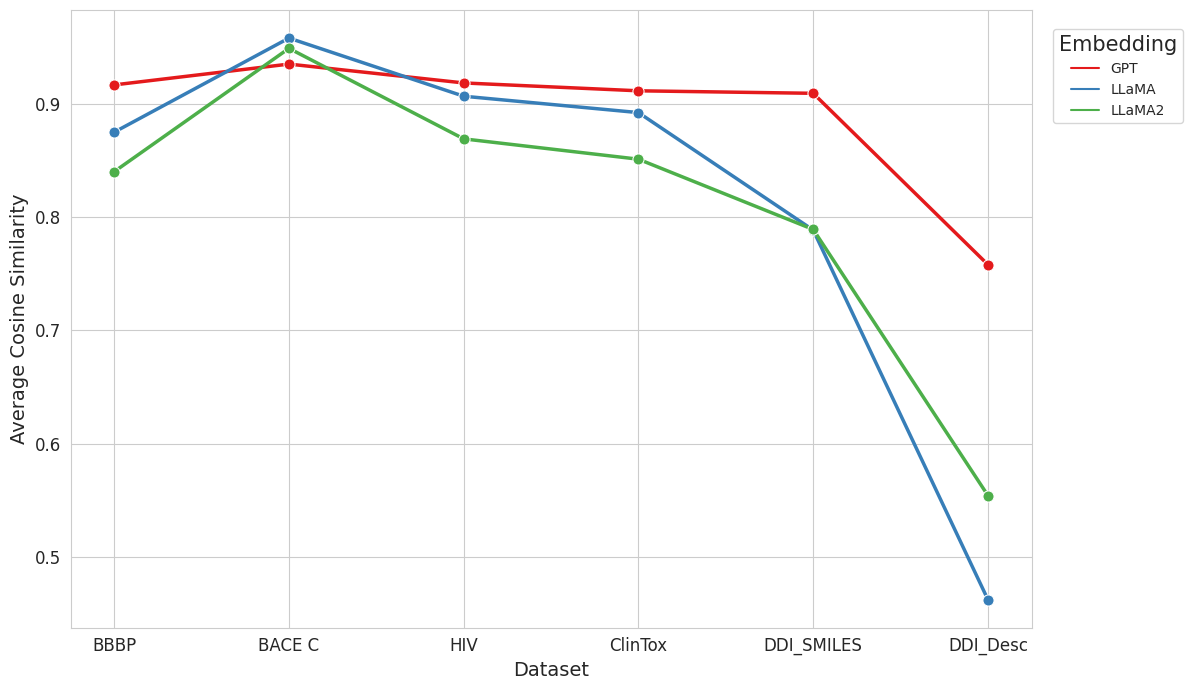

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set1")
# Assuming SimCos is your DataFrame
plt.figure(figsize=(12, 7))

sns.lineplot(data=SimCos, x="DataSet", y="Avarage Cosine Similarity", hue="Embedding",
             marker='o', markersize=8, linewidth=2.5,palette='Set1')

#plt.title('Average Cosine Similarity by Model and DataSet', fontsize=18, fontweight='bold')
plt.ylabel('Average Cosine Similarity', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend(title='Embedding', title_fontsize=15, loc='upper center', bbox_to_anchor=(1.09, 0.98), fancybox=True, ncol=1, fontsize=10)

plt.tight_layout()

# Replace PATH with your actual path
plt.savefig('Result_simcos_GvL.pdf')
plt.show()

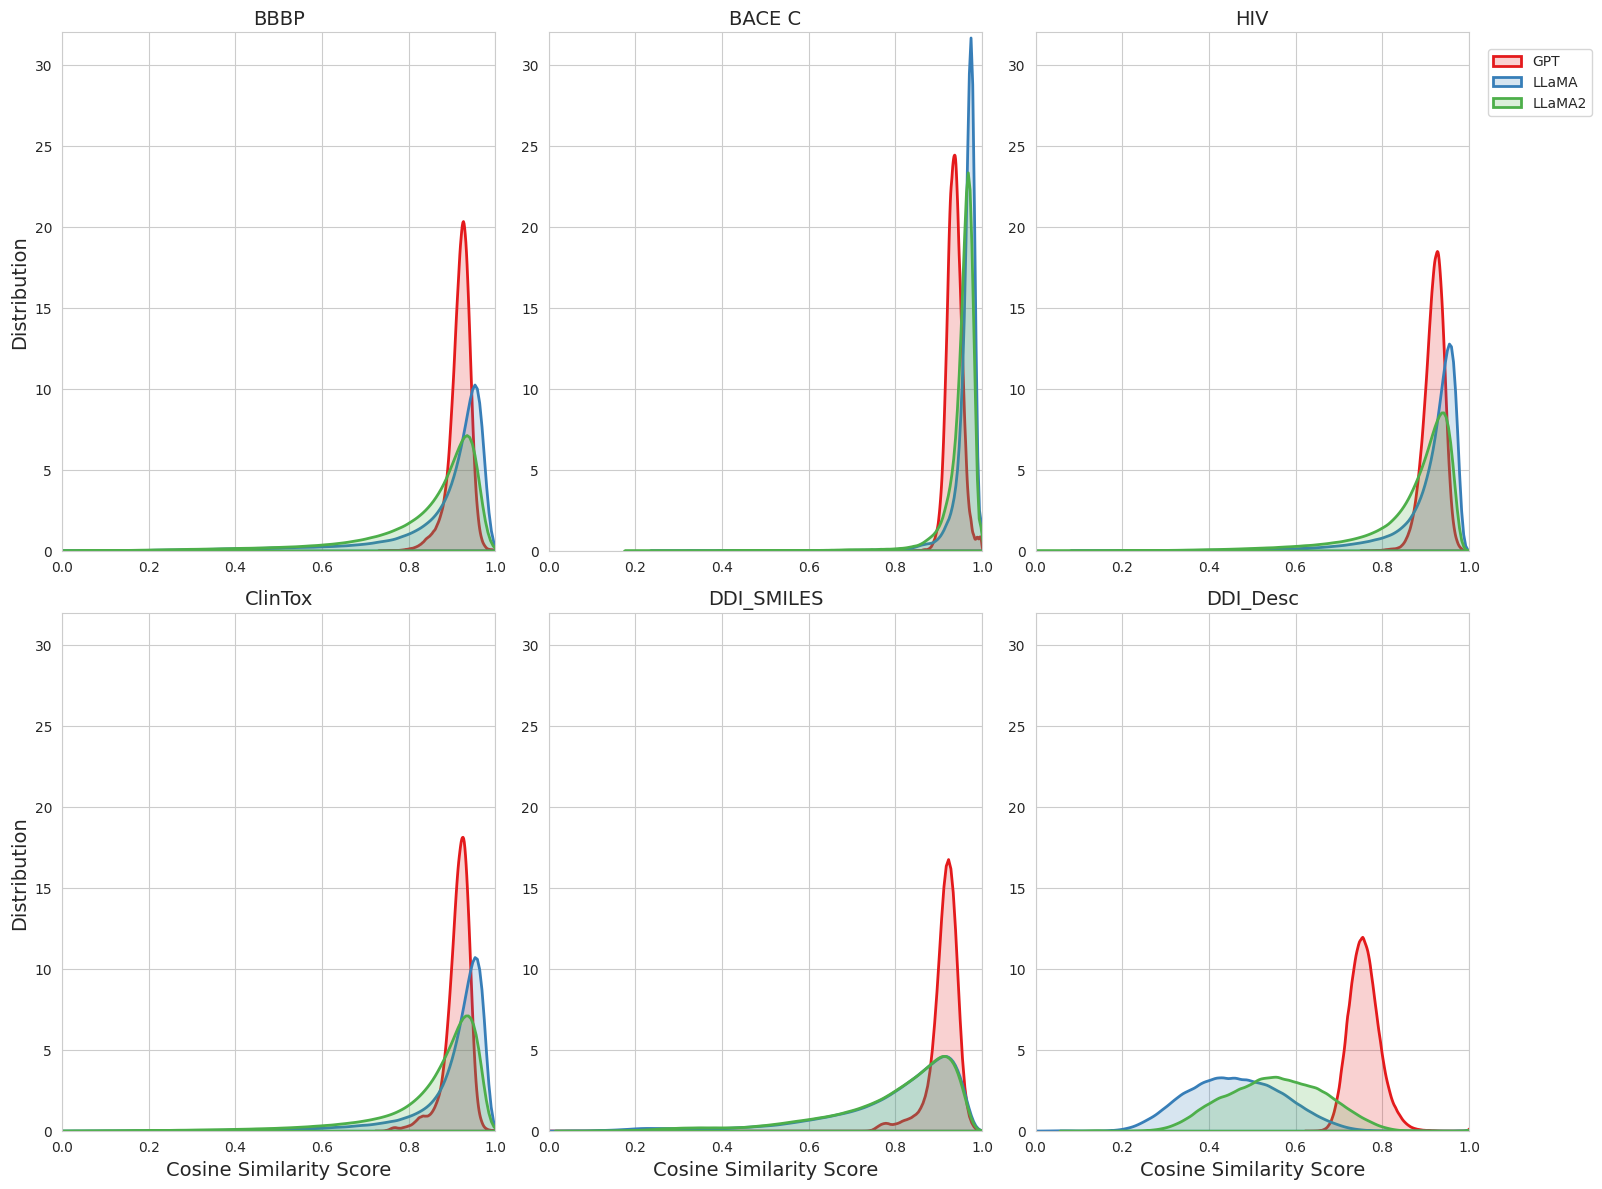

In [84]:
DATASETS = ['BBBP', 'BACE C', 'HIV','ClinTox','DDI_SMILES','DDI_Desc']
MODELS = ['GPT','LLaMA','LLaMA2']
sns.set_style("whitegrid")
sns.set_palette("Set1")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
handles, labels = [], []

axes = axes.flatten()

for i, d in enumerate(DATASETS):
    df = pd.DataFrame()

    for j, m in enumerate(MODELS):
        if d in ['HIV', 'DDI_SMILES', 'DDI_Desc']:
            df_sampled = new_embeddings[m][d].sample(n=2000, random_state=1)
        else:
            df_sampled = new_embeddings[m][d]

        cosine_sim_matrix = cosine_similarity(df_sampled)
        upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
        cosine_sim_scores = cosine_sim_matrix[upper_triangle_indices]

        df[m] = cosine_sim_scores

        del(cosine_sim_matrix, upper_triangle_indices, cosine_sim_scores)

    ax = axes[i]
    for m in MODELS:
        sns.kdeplot(data=df, x=m, lw=2, label=m, fill=True, common_norm=False, alpha=.2, ax=ax)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 32)
    ax.set_title(f'{d}',fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i % ncols == 0:  # Leftmost subplot
        ax.set_ylabel('Distribution',fontsize=14)
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Cosine Similarity Score',fontsize=14)
# Gather the handles and labels for the legend
    for handle in ax.get_legend_handles_labels()[0]:
        if handle not in handles:
            handles.append(handle)
    for label in ax.get_legend_handles_labels()[1]:
        if label not in labels:
            labels.append(label)

# Create a single legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.03, 0.96), ncol=1, title_fontsize=15, fancybox=True, fontsize=10)
# Adjust the layout
plt.tight_layout()


# Save the figure with bbox_inches='tight' to include everything
plt.savefig('all_cosSim.pdf', bbox_inches='tight')
plt.show()


#Visualise the Embeddings

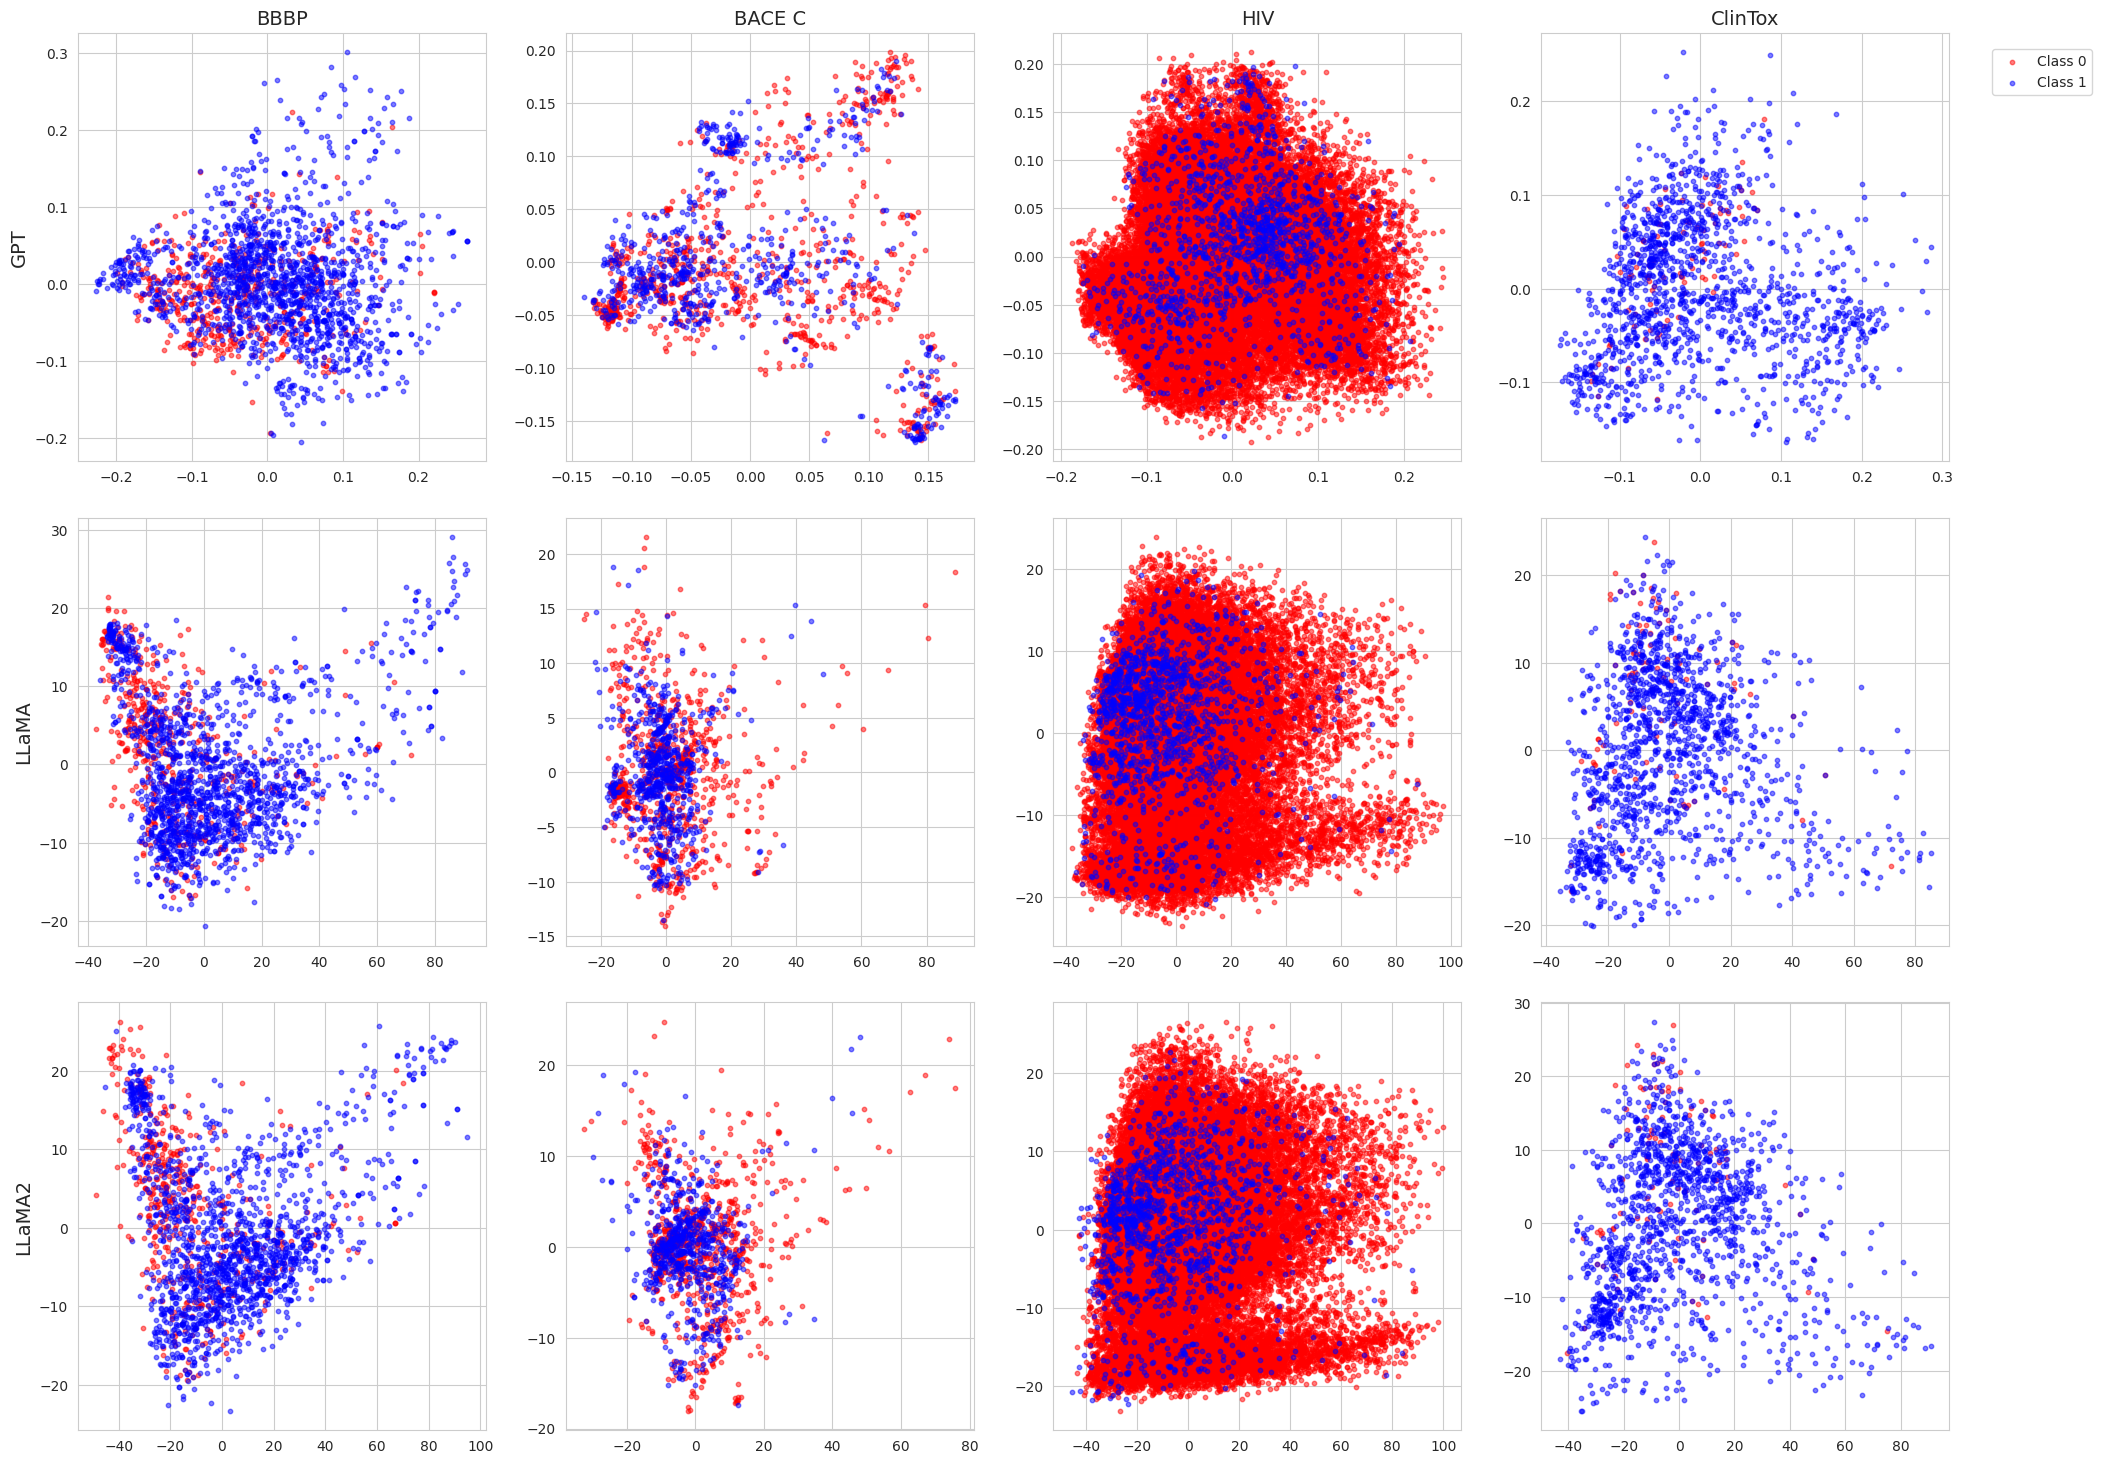

In [87]:
DATASETS = ['BBBP', 'BACE C', 'HIV','ClinTox']

n_rows = len(MODELS)
n_cols = len(DATASETS)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

plot_idx = 0
handles, labels = None, None

for i, m in enumerate(MODELS):
    for j, d in enumerate(DATASETS):
        ax = axes[plot_idx]

        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(new_embeddings[m][d])

        features_class_0 = features_pca[data[d]['LABELS'] == 0]
        features_class_1 = features_pca[data[d]['LABELS'] == 1]

        ax.scatter(features_class_0[:, 0], features_class_0[:, 1], c='red', s=10, label='Class 0', alpha=0.5)
        ax.scatter(features_class_1[:, 0], features_class_1[:, 1], c='blue', s=10, label='Class 1', alpha=0.5)


        ax.grid(True)

        # Set y-axis labels for the first column and x-axis labels for the bottom row
        if j == 0:  # First column
            ax.set_ylabel(f'{m}',fontsize=14)
        if i == 0:  # Bottom row
            ax.set_title(f'{d}',fontsize=14)

        # Store handles and labels for the legend
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()

        plot_idx += 1

# Create a single legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.03, 0.96), ncol=1, title_fontsize=15, fancybox=True, fontsize=10)

plt.tight_layout(pad=2.0)
plt.savefig('PCA.pdf', bbox_inches='tight')
plt.show()



## Evaluate Embeddings

In [88]:
def balance_df(df):
  zeros = df['LABELS'].value_counts().get(0.0, 0)
  ones = df['LABELS'].value_counts().get(1.0, 0)

  if ones > 4 * zeros:
    majority, minority = 1.0, 0.0
  elif zeros > 4 * ones:
    majority, minority = 0.0, 1.0
  else:
    return df

  SCALE = 4

  majority_class = df[df['LABELS'] == majority]
  minority_class = df[df['LABELS'] == minority]
  num_samples = int(len(minority_class) * SCALE)
  majority_downsampled = resample(majority_class, replace=False, n_samples=num_samples)

  return pd.concat([majority_downsampled, minority_class])

def separate_df(df):
  smiles = list(df['SMILES'])
  labels = list(df['LABELS'])
  #features = []
  features=df.drop(['SMILES','LABELS'], axis=1)
  return [smiles, features, labels]

def scaffold_split_data(smiles, embeddings, labels):
  df = dc.data.DiskDataset.from_numpy(X=embeddings,y=labels,w=np.zeros(len(smiles)),ids=smiles)
  scaffoldsplitter = dc.splits.ScaffoldSplitter()
  train, test = scaffoldsplitter.train_test_split(df)
  return [train.X, test.X, train.y, test.y]

In [89]:
def get_results(test_labels, y_pred):
  accuracy = accuracy_score(test_labels, y_pred)
  prec = precision_score(test_labels, y_pred, pos_label=1.0)
  recall = recall_score(test_labels, y_pred,  pos_label=1.0)
  f1 = f1_score(test_labels, y_pred,  pos_label=1.0)
  aucroc = roc_auc_score(test_labels, y_pred)
  aucpr = average_precision_score(test_labels, y_pred)

  return [accuracy, prec, recall, f1, aucroc, aucpr]

In [90]:
def x(a):
  if a > 0.5:
    return 1.0
  return 0.0

In [91]:
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

def classify(classifier, train_features, test_features, train_labels, test_labels):
  classifiers = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=10000),
    'SVM': SVC(C=5.0, probability=True),
    'RandomForestClassifier': RandomForestClassifier(max_depth=5),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
  }
  clf = classifiers[classifier]
  clf.fit(train_features, train_labels)
  y_pred = clf.predict(test_features)

  #y_pred = list(map(x, y_pred))

  return get_results(test_labels, y_pred)


In [92]:
RUNS = 5
results = {}
df_result=pd.DataFrame()
#DATASETS = ['bbbp', 'bace_classification','hiv', 'clintox']

#MODELS = ['GPT','llama-7B','llama2-7B']

CLASSIFIERS = ['LogisticRegression','SVM', 'RandomForestClassifier', 'GradientBoostingClassifier']

for model in MODELS:
    results[model] = {}
    for dataset in DATASETS:
        results[model][dataset] = {}
        for classifier in CLASSIFIERS:
            results[model][dataset][classifier] = pd.DataFrame()
            for i in range(RUNS):
                df = pd.concat([pd.DataFrame({'SMILES': data[dataset]['SMILES']}),
                                pd.DataFrame({'LABELS': data[dataset]['LABELS']}),
                                pd.DataFrame(np.array(new_embeddings[model][dataset]))], axis=1)
                smiles, features, labels = separate_df(balance_df(df))
                train_features, test_features, train_labels, test_labels = train_test_split(features, labels, stratify=labels)
                accuracy, prec, recall, f1, aucroc, aucpr = classify(classifier, train_features, test_features, train_labels, test_labels)

                newFrame = pd.DataFrame({"Accuracy": accuracy, "Precision": prec, "recall": recall,
                                         "F1_score": f1, "AUCROC": aucroc, "AUCPR": aucpr}, index=[i])
                results[model][dataset][classifier] = pd.concat([results[model][dataset][classifier], newFrame])

for model in results:
    for dataset in results[model]:
        for classifier in results[model][dataset]:
            df = results[model][dataset][classifier]
            avg_std = df.agg(['mean', 'std']).round(4)
            avg_std_str = avg_std.apply(lambda x: f"{x['mean']} ± {x['std']}", axis=0)
            results[model][dataset][classifier] = avg_std_str
            df_result = df_result.append({
                "Classifier": classifier,
                "Model": model,
                "Dataset": dataset,
                "Accuracy": results[model][dataset][classifier]['Accuracy'],
                "Precision": results[model][dataset][classifier]['Precision'],
                "recall": results[model][dataset][classifier]['recall'],
                "F1_score": results[model][dataset][classifier]['F1_score'],
                "AUCROC": results[model][dataset][classifier]['AUCROC'],
                "AUCPR": results[model][dataset][classifier]['AUCPR']
            }, ignore_index=True)


df_result

,Classifier,Model,Dataset,Accuracy,Precision,recall,F1_score,AUCROC,AUCPR
0,LogisticRegression,GPT,BBBP,0.7757 ± 0.0038,0.7743 ± 0.0031,0.9974 ± 0.0018,0.8718 ± 0.0019,0.5262 ± 0.0084,0.7743 ± 0.0031
1,SVM,GPT,BBBP,0.8627 ± 0.016,0.8723 ± 0.0144,0.9615 ± 0.0139,0.9147 ± 0.0097,0.7516 ± 0.0295,0.8681 ± 0.0138
2,RandomForestClassifier,GPT,BBBP,0.8267 ± 0.0116,0.8226 ± 0.0086,0.9862 ± 0.0088,0.8969 ± 0.0068,0.6472 ± 0.0204,0.8218 ± 0.0086
3,GradientBoostingClassifier,GPT,BBBP,0.8545 ± 0.0071,0.8654 ± 0.0081,0.959 ± 0.0081,0.9098 ± 0.0042,0.737 ± 0.0161,0.8613 ± 0.0075
4,LogisticRegression,GPT,BACE C,0.6929 ± 0.011,0.7175 ± 0.0159,0.5399 ± 0.023,0.6159 ± 0.0175,0.6806 ± 0.0116,0.5975 ± 0.0115
5,SVM,GPT,BACE C,0.7678 ± 0.0169,0.7333 ± 0.0219,0.7734 ± 0.035,0.7524 ± 0.0197,0.7683 ± 0.0172,0.6705 ± 0.0191
6,RandomForestClassifier,GPT,BACE C,0.7636 ± 0.022,0.7454 ± 0.0183,0.7318 ± 0.0495,0.738 ± 0.0312,0.761 ± 0.0238,0.6683 ± 0.0233
7,GradientBoostingClassifier,GPT,BACE C,0.7778 ± 0.0186,0.7705 ± 0.0251,0.7318 ± 0.024,0.7504 ± 0.0201,0.7741 ± 0.0185,0.6865 ± 0.022
8,LogisticRegression,GPT,HIV,0.8147 ± 0.0051,0.8316 ± 0.0936,0.0925 ± 0.0199,0.1662 ± 0.0339,0.544 ± 0.0105,0.2596 ± 0.0193
9,SVM,GPT,HIV,0.8471 ± 0.0015,0.8844 ± 0.0343,0.2726 ± 0.0184,0.4161 ± 0.0186,0.6317 ± 0.0077,0.3862 ± 0.0059


In [110]:
df_result1=pd.DataFrame()

for model in results:
    for dataset in results[model]:
        for classifier in results[model][dataset]:

            df_result1 = df_result.append({
                "Classifier": classifier,
                "Model": model,
                "Dataset": dataset,
                "Accuracy": results[model][dataset][classifier]['Accuracy'],
                "Precision": results[model][dataset][classifier]['Precision'],
                "recall": results[model][dataset][classifier]['recall'],
                "F1_score": results[model][dataset][classifier]['F1_score'],
                "AUCROC": results[model][dataset][classifier]['AUCROC'],
                "AUCPR": results[model][dataset][classifier]['AUCPR']
            }, ignore_index=True)


df_result1

,Classifier,Model,Dataset,Accuracy,Precision,recall,F1_score,AUCROC,AUCPR
0,LogisticRegression,GPT,BBBP,0.7757 ± 0.0038,0.7743 ± 0.0031,0.9974 ± 0.0018,0.8718 ± 0.0019,0.5262 ± 0.0084,0.7743 ± 0.0031
1,SVM,GPT,BBBP,0.8627 ± 0.016,0.8723 ± 0.0144,0.9615 ± 0.0139,0.9147 ± 0.0097,0.7516 ± 0.0295,0.8681 ± 0.0138
2,RandomForestClassifier,GPT,BBBP,0.8267 ± 0.0116,0.8226 ± 0.0086,0.9862 ± 0.0088,0.8969 ± 0.0068,0.6472 ± 0.0204,0.8218 ± 0.0086
3,GradientBoostingClassifier,GPT,BBBP,0.8545 ± 0.0071,0.8654 ± 0.0081,0.959 ± 0.0081,0.9098 ± 0.0042,0.737 ± 0.0161,0.8613 ± 0.0075
4,LogisticRegression,GPT,BACE C,0.6929 ± 0.011,0.7175 ± 0.0159,0.5399 ± 0.023,0.6159 ± 0.0175,0.6806 ± 0.0116,0.5975 ± 0.0115
5,SVM,GPT,BACE C,0.7678 ± 0.0169,0.7333 ± 0.0219,0.7734 ± 0.035,0.7524 ± 0.0197,0.7683 ± 0.0172,0.6705 ± 0.0191
6,RandomForestClassifier,GPT,BACE C,0.7636 ± 0.022,0.7454 ± 0.0183,0.7318 ± 0.0495,0.738 ± 0.0312,0.761 ± 0.0238,0.6683 ± 0.0233
7,GradientBoostingClassifier,GPT,BACE C,0.7778 ± 0.0186,0.7705 ± 0.0251,0.7318 ± 0.024,0.7504 ± 0.0201,0.7741 ± 0.0185,0.6865 ± 0.022
8,LogisticRegression,GPT,HIV,0.8147 ± 0.0051,0.8316 ± 0.0936,0.0925 ± 0.0199,0.1662 ± 0.0339,0.544 ± 0.0105,0.2596 ± 0.0193
9,SVM,GPT,HIV,0.8471 ± 0.0015,0.8844 ± 0.0343,0.2726 ± 0.0184,0.4161 ± 0.0186,0.6317 ± 0.0077,0.3862 ± 0.0059
